# Tema 1: Teleportación cuántica

En este notebook vamos a trabajar la teleportación cuántica, uno de los protocolos más fundamentales de la computación cuántica. Este ejercicio nos permitirá consolidar y aplicar los conocimientos aprendidos en la unidad anterior sobre entrelazamiento cuántico, mediciones y operaciones condicionales.

La teleportación cuántica es un protocolo que permite transferir el estado cuántico de un qubit (que posee Alice) a otro qubit distante (que posee Bob), sin que la información cuántica viaje físicamente por el espacio. Este proceso requiere:

1. **Un par de qubits entrelazados** compartido previamente entre Alice y Bob
2. **Dos bits clásicos** de información que Alice envía a Bob tras realizar mediciones
3. **Operaciones de corrección** que Bob aplica según los bits clásicos recibidos

Es importante destacar que no se viola el principio de no-clonación cuántica, ya que el estado original en el qubit de Alice se destruye durante el proceso de medición. Tampoco se transmite información más rápido que la luz, pues Bob necesita recibir los dos bits clásicos (a velocidad convencional) para completar la teleportación.

A continuación, implementaremos paso a paso el circuito cuántico completo de teleportación que estudiamos en la teoría, y verificaremos su funcionamiento mediante simulación.

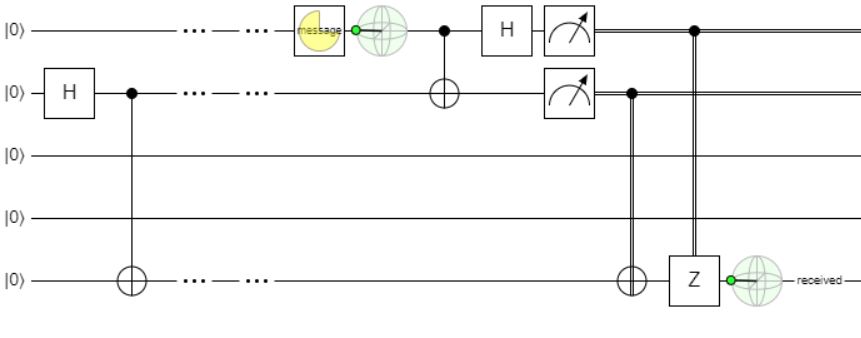

Obtendremos las cuentas de los qubits antes y después de la teleportación.

## **Desarrollo teórico del protocolo de teleportación cuántica**

El protocolo de teleportación cuántica permite transferir un estado cuántico desconocido $|\psi\rangle$ desde Alice hasta Bob utilizando un par de qubits entrelazados y comunicación clásica.

**Estado inicial:**

Supongamos que Alice tiene un qubit en el estado arbitrario:
$$|\psi\rangle = \alpha|0\rangle + \beta|1\rangle$$

donde $|\alpha|^2 + |\beta|^2 = 1$.

Alice y Bob comparten previamente un par de qubits entrelazados en el estado de Bell:
$$|\Phi^+\rangle = \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$$

El estado completo del sistema de tres qubits (Alice, Mensajero, Bob) es:
$$|\psi\rangle \otimes |\Phi^+\rangle = (\alpha|0\rangle + \beta|1\rangle) \otimes \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$$

Expandiendo:
$$= \frac{1}{\sqrt{2}}[\alpha|0\rangle(|00\rangle + |11\rangle) + \beta|1\rangle(|00\rangle + |11\rangle)]$$
$$= \frac{1}{\sqrt{2}}[\alpha|000\rangle + \alpha|011\rangle + \beta|100\rangle + \beta|111\rangle]$$

**Paso 1: Puerta CNOT**

Alice aplica una puerta CNOT entre su qubit y el qubit mensajero:
$$= \frac{1}{\sqrt{2}}[\alpha|000\rangle + \alpha|011\rangle + \beta|110\rangle + \beta|101\rangle]$$

**Paso 2: Puerta Hadamard**

Alice aplica una puerta Hadamard a su qubit:
$$= \frac{1}{2}[\alpha(|0\rangle + |1\rangle)|00\rangle + \alpha(|0\rangle + |1\rangle)|11\rangle + \beta(|0\rangle - |1\rangle)|10\rangle + \beta(|0\rangle - |1\rangle)|01\rangle]$$

Reagrupando según los estados de los dos primeros qubits (Alice y Mensajero):
$$= \frac{1}{2}[|00\rangle(\alpha|0\rangle + \beta|1\rangle) + |01\rangle(\alpha|1\rangle + \beta|0\rangle) + |10\rangle(\alpha|0\rangle - \beta|1\rangle) + |11\rangle(\alpha|1\rangle - \beta|0\rangle)]$$

**Paso 3: Medición**

Alice mide sus dos qubits en la base computacional, obteniendo uno de cuatro resultados posibles (00, 01, 10, 11), cada uno con probabilidad 1/4.

**Paso 4: Corrección**

Según el resultado de la medición de Alice, el qubit de Bob queda en uno de estos estados:
- Si Alice mide **00**: Bob tiene $\alpha|0\rangle + \beta|1\rangle$ → No hace nada (I)
- Si Alice mide **01**: Bob tiene $\alpha|1\rangle + \beta|0\rangle$ → Aplica X
- Si Alice mide **10**: Bob tiene $\alpha|0\rangle - \beta|1\rangle$ → Aplica Z
- Si Alice mide **11**: Bob tiene $\alpha|1\rangle - \beta|0\rangle$ → Aplica ZX

Tras aplicar la corrección apropiada, Bob recupera exactamente el estado original:
$$|\psi\rangle = \alpha|0\rangle + \beta|1\rangle$$

**Propiedades importantes:**
1. El estado original de Alice se destruye durante la medición (no-clonación)
2. Se requieren 2 bits clásicos de comunicación
3. Bob no puede recuperar el estado sin la información clásica de Alice
4. La fidelidad de la teleportación es del 100% en el caso ideal

## Librerías

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_counts
import numpy as np

---
# Circuito cuántico

Vamos a empezar creando el circuito cuántico. Vamos a definir un registro para cada qubit y cada resultado de los 2 que tendrá Alice, para las correcciones.

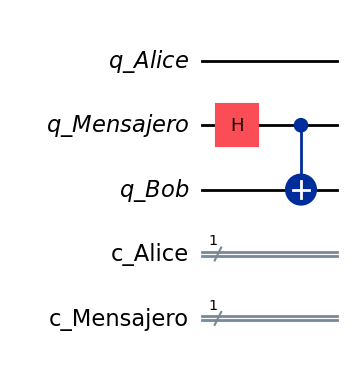

In [5]:
#Creamos los registros separados
qrAlice     = QuantumRegister(1, 'q_Alice')
qrMensajero = QuantumRegister(1, 'q_Mensajero')
qrBob       = QuantumRegister(1, 'q_Bob')

crAlice     = ClassicalRegister(1, 'c_Alice')
crMensajero = ClassicalRegister(1, 'c_Mensajero')

#Creamos el circuito
qc = QuantumCircuit(qrAlice, qrMensajero, qrBob, crAlice, crMensajero)

#Entrelazamos el qubit mensajero con el de Bob
qc.h(qrMensajero[0])
qc.cx(qrMensajero[0], qrBob[0])
qc.draw('mpl')

Inicializamos el estado que queremos en Alice.

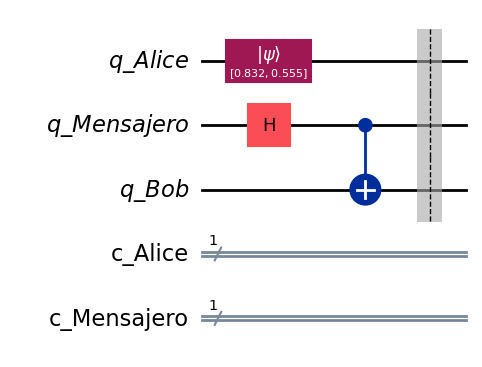

In [6]:
#Vector de estado
state = np.array([0.75, 0.5])
state /= np.sqrt(sum(state**2))
#Inicializamos el qubit y normalizamos el vector
qc.initialize(state, qubits=qrAlice[0], normalize=True)
qc.barrier()
qc.draw('mpl')

Añadimos los entrelazadores entre Alice y el mensajero y medimos.

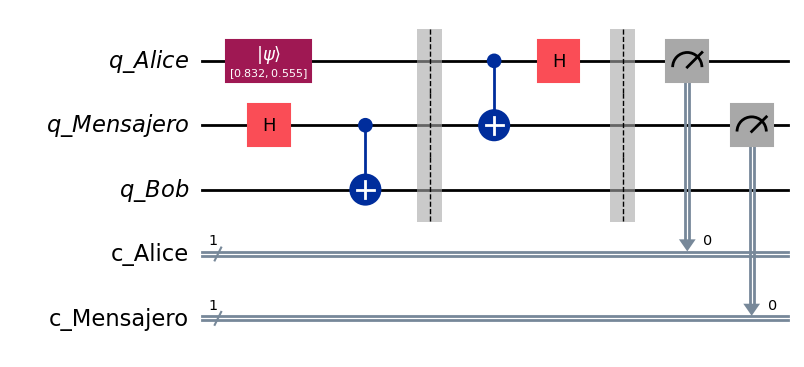

In [7]:
qc.cx(qrAlice[0],qrMensajero[0])
qc.h(qrAlice[0])
qc.barrier()
qc.measure([qrAlice[0], qrMensajero[0]],[crAlice[0], crMensajero[0]])
qc.draw('mpl')

Añadimos las operaciones de corrección condicionadas con los resultados de las mediciones.

In [8]:
with qc.if_test((crAlice[0], 1)) as else_:
    qc.z(2)
with qc.if_test((crMensajero[0], 1)) as else_:
    qc.x(2)

Comprobamos que está bien construido.

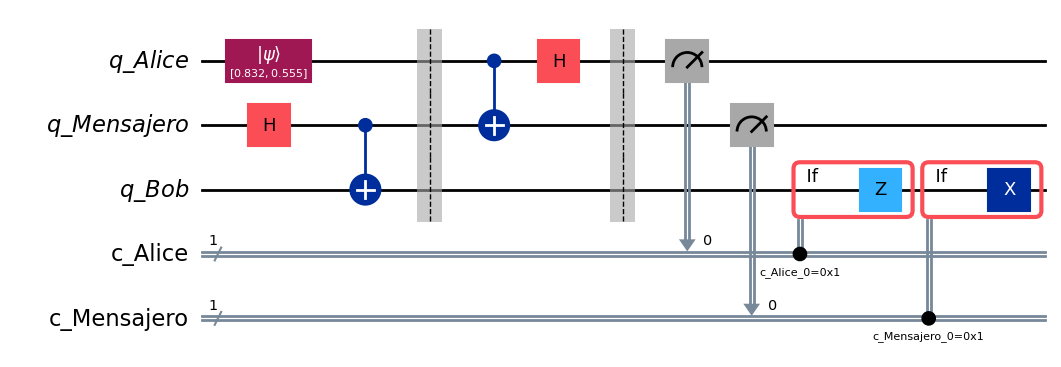

In [9]:
qc.draw('mpl')

Vamos a hacer que esto sea directamente una función.

In [10]:
def teleportacion(estado: np.array):
    #Normalizamos
    estado /= np.sqrt(sum(estado**2))

    #Creamos los registros separados
    qrAlice     = QuantumRegister(1, 'q_Alice')
    qrMensajero = QuantumRegister(1, 'q_Mensajero')
    qrBob       = QuantumRegister(1, 'q_Bob')

    crAlice     = ClassicalRegister(1, 'c_Alice')
    crMensajero = ClassicalRegister(1, 'c_Mensajero')

    #Creamos el circuito
    qc = QuantumCircuit(qrAlice, qrMensajero, qrBob, crAlice, crMensajero)

    #Entrelazamos el qubit mensajero con el de Bob
    qc.h(qrMensajero[0])
    qc.cx(qrMensajero[0], qrBob[0])

    #Inicializamos el qubit y normalizamos el vector
    qc.initialize(estado, qubits=qrAlice[0], normalize=True)
    qc.barrier()

    #Entrelazamos
    qc.cx(qrAlice[0],qrMensajero[0])
    qc.h(qrAlice[0])
    qc.barrier()
    qc.measure([qrAlice[0], qrMensajero[0]],[crAlice[0], crMensajero[0]])

    #Corrección
    with qc.if_test((crAlice[0], 1)) as else_:
        qc.z(2)
    with qc.if_test((crMensajero[0], 1)) as else_:
        qc.x(2)

    return qc

---
# Comprobación del algoritmo

Obtengamos las cuentas finales.

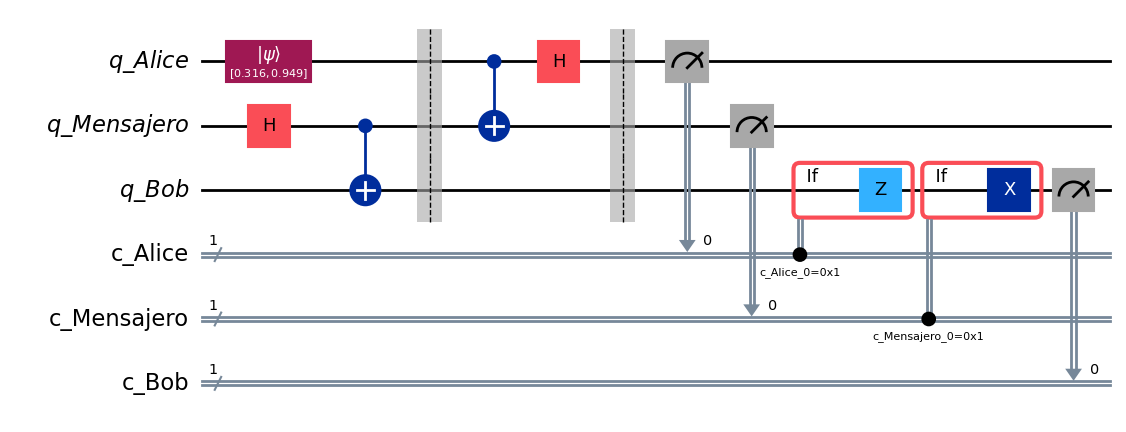

In [11]:
#Estado de entrada
estado = np.array([1,3], dtype=float)
estado /= np.sqrt(sum(estado**2))

#Creamos el circuito
qc = teleportacion(estado)

#Añadimos un registro extra para ver el estado final
crBob = ClassicalRegister(1, 'c_Bob')
qc.add_register(crBob)

qc.measure(2, 2)
qc.draw('mpl')

Transpilamos y ejecutamos el circuito en simulador.
Para ejecutar el circuito cuántico en un simulador, seguimos estos pasos:

1. **Selección del backend**: Utilizamos `AerSimulator()` que es un simulador local de Qiskit que emula el comportamiento de un ordenador cuántico real.

2. **Transpilación**: El proceso de transpilación (`transpile()`) adapta nuestro circuito cuántico abstracto al conjunto de instrucciones específicas que puede ejecutar el backend seleccionado. Esto incluye:
   - Descomponer las compuertas en compuertas nativas del hardware
   - Optimizar el circuito para reducir su profundidad
   - Mapear los qubits lógicos a qubits físicos

3. **Ejecución**: Con `backend.run()` enviamos el circuito transpilado al simulador para su ejecución. Esto devuelve un objeto `job` que representa la tarea en ejecución.

4. **Obtención de resultados**: Llamamos a `job.result()` para obtener los resultados de la ejecución, y luego `get_counts()` para extraer las cuentas (frecuencias) de cada estado medido.

5. **Visualización**: Finalmente, `plot_histogram()` nos permite visualizar gráficamente la distribución de probabilidades de los estados medidos.

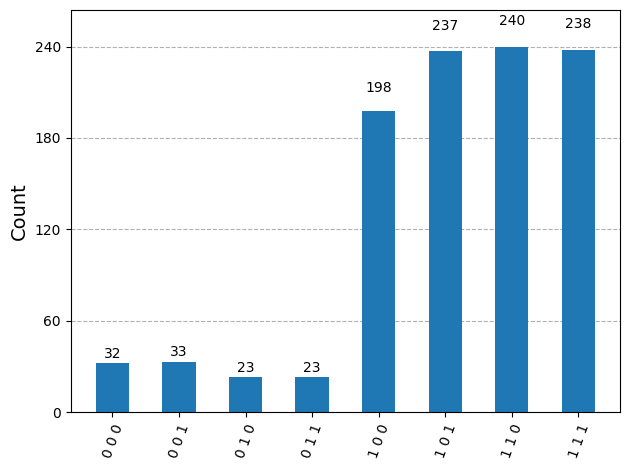

In [12]:
backend = AerSimulator()

qc_transpiled = transpile(qc, backend)

#Creamos el job
job = backend.run(qc_transpiled)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)

Vamos a obtener solamente las cuentas del último qubit. Para eso usamos las cuentas marginales.

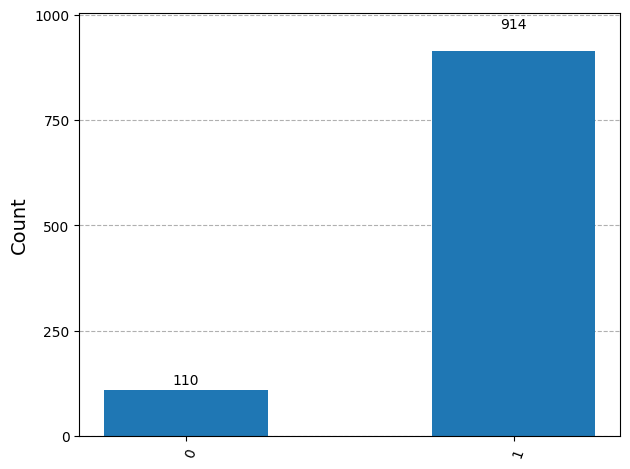

In [13]:
estado = np.array([1,3], dtype=float)
estado /= np.sqrt(sum(estado**2))

qc = teleportacion(estado)

#Añadimos un registro extra para ver el estado final
crBob = ClassicalRegister(1, 'c_Bob')
qc.add_register(crBob)

qc.measure(2, 2)
qc.draw('mpl')

backend = AerSimulator()

qc_transpiled = transpile(qc, backend)

#Creamos el job
job = backend.run(qc_transpiled)
result = job.result()

# Indicamos cual es el registro de interes
indices = [2]

result_marginal = marginal_counts(result, indices=indices)
marginal_counts_value = result_marginal.get_counts()

plot_histogram(marginal_counts_value)

In [14]:
estado**2

array([0.1, 0.9])

Podemos ver que coinciden, salvo un error estadístico por no tener mediciones infinitas.